## Analysis for Week 2: Mac Hand Data Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def import_data():  
    #Importing data
    data = pd.read_csv('./Data/MacHandData.csv')

    #Cleaning Dataframe
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    

    #NA'ing Outliers
    data.loc[data.total_score > 100, 'total_score'] = np.nan
    
    return data


def preprocess(df):
    df = df.copy()
    df['individual_id'] = df['subject_id'].str[:-2]
    df['hand'] = df['subject_id'].str[-1]
    return df.drop(columns=['subject_id'])

def get_iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

In [2]:
#Importing data
data = pd.read_csv('./Data/MacHandData.csv')


def label_score_classes(row):
    if row['hand_is_dominant_'] == 0 and row['hand_is_affected_'] == 0:
        return 'Non-Dominant Non-Affected'
    elif row['hand_is_dominant_'] == 0 and row['hand_is_affected_'] == 1:
        return 'Non-Dominant Affected'
    elif row['hand_is_dominant_'] == 1 and row['hand_is_affected_'] == 0:
        return 'Dominant Non-Affected'
    elif row['hand_is_dominant_'] == 1 and row['hand_is_affected_'] == 1:
        return 'Dominant Affected'


# Remove individual with two affected hands, as scores are missing

### Summary statistics by individual

Gets number of trials for each participant, per hand.

In [3]:
trial_counts_df = preprocess(import_data())\
    .groupby(['individual_id', 'hand'])\
    .size()\
    .reset_index(name='counts')

trial_counts_df

,individual_id,hand,counts
0,001H,L,2
1,001H,R,2
2,002H,L,2
3,002H,R,2
4,003H,L,3
...,...,...,...
79,040N,R,2
80,041N,L,3
81,041N,R,2
82,042N,L,3


We see below that all participants perform the task at least once with both hands.

In [4]:
trial_counts_summary = trial_counts_df.groupby('individual_id').size().reset_index(name='num_hands')
filtered_counts = trial_counts_summary[trial_counts_summary['num_hands'] != 2]

filtered_counts.count()

individual_id    0
num_hands        0
dtype: int64

Descriptive stats on task completion:

In [5]:
df = preprocess(import_data())

df_right = df[df['hand'] == 'R']
df_left = df[df['hand'] == 'L']

df_right

# print(f'Participants perform the task with their right hand a median of {df_right["counts"].median()} times, with an IQR of {get_iqr(df_right["counts"])} times.')
# print(f'Participants perform the task with their left hand a median of {df_left["counts"].median()} times, with an IQR of {get_iqr(df_left["counts"])} times.')

,dominance,affected_side,age,sex,task1,total_score,individual_id,hand
2,0,0,52,0,4,82.0,001H,R
3,0,0,52,0,4,80.0,001H,R
6,1,1,47,0,5,91.0,002H,R
7,1,1,47,0,5,94.0,002H,R
11,0,1,42,0,5,98.0,003H,R
...,...,...,...,...,...,...,...,...
188,0,1,22,0,5,97.0,040N,R
192,0,1,63,1,5,94.0,041N,R
193,0,1,63,1,5,94.0,041N,R
197,0,1,31,0,5,99.0,042N,R


### Descriptive stats on dominance and affected side

Reported stats are on the level of the individual, not on the level of the trial. This is important since different individuals sometimes perform different numbers of trials.

In [6]:
das_by_individual = preprocess(import_data())\
    .groupby(['individual_id'])\
    .agg({'dominance': 'first', 'affected_side': 'first'})\
    .reset_index()

df = das_by_individual.groupby(['dominance', 'affected_side'])\
    .agg({'individual_id': 'count'})\
    .rename(columns={'individual_id': 'count'})\
    .reset_index()

df['proportion'] = df['count'] / df['count'].sum()

df_labelled = df
df_labelled.columns

df_labelled['dominance'] = df_labelled['dominance'].map(lambda x: 'Right' if x == 0 else 'Left')
df_labelled['affected_side'] = df_labelled['affected_side'].map(lambda x: 'Right' if x == 0 else ('Left' if x == 1 else 'Both'))

df_labelled

df_summary = df_labelled

df_summary['affected_side_dominance'] = df_summary.apply(lambda row: 'Dominant' if row['dominance'] == row['affected_side']\
            else ('Both Affected' if row['affected_side'] == 'Both' else 'Non-dominant'), axis=1)

df_summary = df_summary.groupby('affected_side_dominance').agg({'count': 'sum', 'proportion': 'sum'}).reset_index()
df_summary


,affected_side_dominance,count,proportion
0,Both Affected,1,0.02381
1,Dominant,20,0.47619
2,Non-dominant,21,0.50000


There are 20 participants whose dominant hand was affected, 21 participants whose non-dominant hand was affected, and one participant for whom both hands were affected by traumatic injury.

### Demographic Descriptive Stats: Proportions



In [7]:
data = preprocess(import_data())
data

,dominance,affected_side,age,sex,task1,total_score,individual_id,hand
0,0,0,52,0,5,97.0,001H,L
1,0,0,52,0,5,99.0,001H,L
2,0,0,52,0,4,82.0,001H,R
3,0,0,52,0,4,80.0,001H,R
4,1,1,47,0,4,58.0,002H,L
...,...,...,...,...,...,...,...,...
194,0,1,31,0,4,89.0,042N,L
195,0,1,31,0,4,88.0,042N,L
196,0,1,31,0,4,89.0,042N,L
197,0,1,31,0,5,99.0,042N,R


In [8]:
#Proportions of Dominance

num_participants = data['individual_id'].nunique()
dominance_df = data.groupby('dominance').agg({'individual_id': 'nunique'}).reset_index()
dominance_df

# dominance_df['proportion'] = dominance_df['individual_id'] / num_participants

# #Relabel
# dominance_df['dominance'] = dominance_df['dominance'].map(lambda x: 'Right' if x == 0 else 'Left')

# dominance_df


,dominance,individual_id
0,0,38
1,1,4


In [9]:
# Proportions of Affected Side

num_participants = data['individual_id'].nunique()

aff_side_df = data.groupby('affected_side').agg({'individual_id': 'nunique'}).reset_index()
aff_side_df['proportion'] = aff_side_df['individual_id'] / num_participants

#Relabel
aff_side_df['affected_side'] = aff_side_df['affected_side'].map(lambda x: 'Right' if x == 0 else ('Left' if x == 1 else 'Both'))


aff_side_df


,affected_side,individual_id,proportion
0,Right,22,0.52381
1,Left,20,0.47619
2,Both,1,0.02381


50.0
21.25
16.940560155945626


<Axes: >

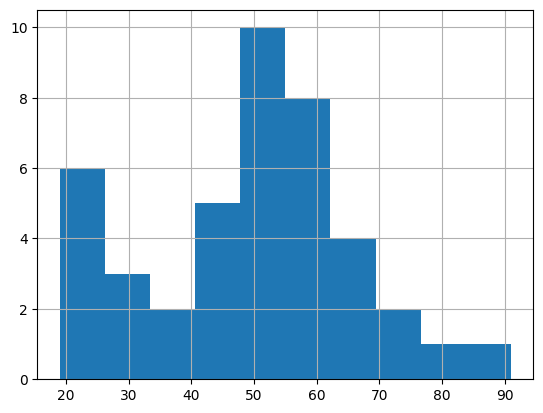

In [10]:
# Verify that each individual has one age

df = data.groupby('individual_id').agg({'age': 'first'})
print(df['age'].median())
print(get_iqr(df['age']))
print(df['age'].std())


# Get mean age
df['age'].hist()

Boxplots for Task1 Score and Total Score by Affected Hand Dominance

In [11]:
df = preprocess(import_data())

df
df[df['affected_side'] == 2]

,dominance,affected_side,age,sex,task1,total_score,individual_id,hand
86,0,2,61,0,3,NaN,020H,L
87,0,2,61,0,3,NaN,020H,L
88,0,2,61,0,2,NaN,020H,R
89,0,2,61,0,2,NaN,020H,R


In [12]:
df = preprocess(import_data())



df['dominance'] = df['dominance'].map(lambda x: 'Right' if x == 0 else 'Left')
df['affected_side'] = df['affected_side'].map(lambda x: 'Right' if x == 0 else ('Left' if x == 1 else 'Both'))
df['hand'] = df['hand'].map(lambda x: 'Right' if x == 'R' else 'Left')

df['hand_is_dominant'] = df.apply(lambda row: 1 if row['dominance'] == row['hand'] else 0, axis=1)
df['hand_is_affected'] = df.apply(lambda row: 1 if ((row['affected_side'] == row['hand'] or row['affected_side'] == 'Both')) else 0, axis=1)

df_summary = df.groupby(['hand_is_dominant', 'hand_is_affected']).agg({'total_score': ['median', get_iqr], 'task1': ['median', get_iqr]}).reset_index()

# Collapse Multi-index DF
df_summary.columns = ['_'.join(map(str, col)).strip() for col in df_summary.columns.values]


df_summary

,hand_is_dominant_,hand_is_affected_,total_score_median,total_score_get_iqr,task1_median,task1_get_iqr
0,0,0,96.5,4.0,5.0,0.0
1,0,1,79.0,19.0,4.0,1.0
2,1,0,96.0,3.0,5.0,0.0
3,1,1,91.0,21.0,5.0,1.0
